# Race Studio 3 Data Processing

## Initial Configuration

Run this module before running anything else.

In [1]:
import pint
import pandas as pd
import pint_pandas
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

u = pint.UnitRegistry()
Q_ = u.Quantity
u.define('percent = pct = dimensionless / 100')
u.define('gear = dimensionless')

pint_pandas.PintType.ureg = u
pint_pandas.PintType.ureg.setup_matplotlib()

## Initialize Race Data from Spreadsheet

This code takes formatted race data from a `.csv` file and parses it into [`Pandas Dataframes`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html), [`Pint`](https://pint.readthedocs.io/en/stable/) Unit objects, and [`Pint Pandas`](https://pint.readthedocs.io/en/0.18/pint-pandas.html) dataframe extension so that computations can be easily performed on the data.

In [2]:
RACE_DATA_FILEPATH = "data/formatted/BETTER_20230831_143833_Blair Hosie_Rush SR 150_Palmer ACW_a_0045.csv"
UNITS = {}

def generate_units_dict(csv_filepath: str) -> dict[str, str]:
    """
    Generate a dictionary of units from a CSV file.

    This function reads the first row of a CSV file specified by the
    file path.  It then generates and returns a dictionary where each
    key-value pair corresponds to a column label and its associated
    unit. If a unit is not specified (empty or consisting only of
    spaces) for a label, it is replaced with 'dimensionless'.
    Additionally, any spaces are removed from the units, and
    percentage symbols are replaced with the word 'percent'.

    Parameters
    ----------
    csv_filepath : str
        The file path to the CSV file from which units are to be
        extracted.

    Returns
    -------
    dict[str, str]
        A dictionary where each key is a column label from the CSV and
        each value is the cleaned unit associated with that label.
        'Dimensionless' is used for labels without specified units.

    Examples
    --------
    >>> generate_units_dict('data.csv')
    {'Temperature': 'Celsius', 'Humidity': 'percent', 'Pressure': 'dimensionless'}
    """
    units_data = pd.read_csv(
        filepath_or_buffer=csv_filepath,
        nrows=1,
    ).to_dict(orient='list')

    for label, unit in units_data.items():
        if unit[0].replace(' ', '') == '':
            unit[0] = 'dimensionless'
        UNITS[label] = unit[0].replace(' ', '').replace('%', 'percent')

    return UNITS


# def assign_df_units(df: pd.DataFrame | pd.Series, units: str) -> pd.DataFrame | pd.Series:
#     return df.apply(lambda val: Q_(val, u(units)))


# def set_column_units(df: pd.DataFrame, col_name: str) -> None:
#     assert col_name in df.keys(), f'Column "{col_name}" does not appear in the dataframe'
#     df[col_name] = assign_df_units(df[col_name], UNITS[col_name])


# def initialize_col_units(df: pd.DataFrame) -> None:
#     for col_name in df:
#         print(f'INITIALIZING:    {col_name}')
#         set_column_units(df=df, col_name=col_name)

def load_race(race_data_filepath: str):
    """
    Load race data from a CSV file and quantify the units using Pint.

    This function reads race data from a specified CSV file.  The CSV
    file is expected to have a multi-level header, with the first
    level being the data labels and the second level being the units.
    After loading the data, it uses the `generate_units_dict` function
    to process and clean the units from the same CSV file.  Finally,
    the function applies Pint's quantify method to the data frame,
    which assigns the units to the data based on the second level of
    the header, allowing for unit-aware calculations.

    Parameters
    ----------
    race_data_filepath : str
        The file path to the CSV file containing the race data.

    Returns
    -------
    pandas.DataFrame
        A pandas DataFrame containing the race data, with units
        applied to the data according to the second header row of the
        CSV file.  This DataFrame is compatible with Pint for
        unit-aware calculations.

    Examples
    --------
    >>> RACE_DATA_DF = load_race('race_data.csv')
    >>> RACE_DATA_DF.dtypes
    <output showing data types and units>
    """
    race_data = pd.read_csv(
        filepath_or_buffer=race_data_filepath,
        header=[0,1],
    )
    generate_units_dict(csv_filepath=race_data_filepath)

    return race_data.pint.quantify(level=-1)

RACE_DATA_DF = load_race(RACE_DATA_FILEPATH)
"""All Race Data stored in a Pandas Dataframe with Pint Units built-in to handle unit conversions and unit operations"""

'All Race Data stored in a Pandas Dataframe with Pint Units built-in to handle unit conversions and unit operations'

## Set Custom Columns

This is where custom columns and math channels are defined.  The master `RACE_DATA_DF` dataframe includes all race data, including columns for these newly defined channels.

In [3]:
def set_dt(df: pd.DataFrame = RACE_DATA_DF) -> None:
    label = 'dT'
    UNITS[label] = 'sec'
    df[label] = df['Time'].diff().fillna(0)  # Calculate time difference between measurements


def set_acceleration(df: pd.DataFrame = RACE_DATA_DF) -> None:
    label = 'Acceleration'
    UNITS[label] = 'm/(s^2)'
    df[label] = (df['GPS Speed'].diff().fillna(0) / df['dT'].replace(0, np.nan))  # Avoid division by zero


def set_Distance_on_GPS_Speed(df: pd.DataFrame = RACE_DATA_DF) -> None:
    """Set "Distance on GPS Speed" Math Channel

    Distance on GPS Speed.

    Parameters
    ----------
    df : pd.DataFrame, optional
        Race Data Dataframe, by default RACE_DATA_DF
    """
    label = 'Distance on GPS Speed'
    UNITS[label] = 'm'
    df[label] = (df['GPS Speed'].shift().fillna(0) * df['dT'].shift().fillna(0)).cumsum()


def set_GPS_G_Sum(df: pd.DataFrame = RACE_DATA_DF) -> None:
    """Set "GPS G Sum" Math Channel

    Outputs the abs value of the sum of the inline and lateral
    acceleration channels values.

    Parameters
    ----------
    df : pd.DataFrame, optional
        Race Data Dataframe, by default `RACE_DATA_DF`
    """
    label = 'GPS G Sum'
    UNITS[label] = 'gravity'
    df[label] = (df['GPS LonAcc']**2 + df['GPS LatAcc']**2)**(1/2)


def set_GPS_BRK_On(df: pd.DataFrame = RACE_DATA_DF) -> None:
    """Set "GPS BRK On" Math Channel

    Computes when the inline acceleration g's are less than -0.15g.
    The outputs are : 0 = Brakes are off, 1 = Brakes are on.

    Parameters
    ----------
    df : pd.DataFrame, optional
        Race Data Dataframe, by default `RACE_DATA_DF`
    """
    label = 'GPS BRK On'
    UNITS[label] = 'dimensionless'
    df[label] = pd.Series(np.where(df['GPS LonAcc'] < Q_(-0.15, 'gravity'), Q_(1, UNITS[label]), Q_(0, UNITS[label])), dtype=f'pint[{UNITS[label]}]')


def set_GPS_TPS_On(df: pd.DataFrame = RACE_DATA_DF) -> None:
    """Set "GPS TPS On" Math Channel

    Computes when the inline acceleration g's are greater than 0.05g.
    The outputs are: 0 = Throttle is off, 1 = Throttle is on.

    Parameters
    ----------
    df : pd.DataFrame, optional
        Race Data Dataframe, by default `RACE_DATA_DF`
    """
    label = 'GPS TPS On'
    UNITS[label] = 'dimensionless'
    df[label] = pd.Series(np.where(df['GPS LonAcc'] > Q_(0.05, 'gravity'), Q_(1, UNITS[label]), Q_(0, UNITS[label])), dtype=f'pint[{UNITS[label]}]')


def set_GPS_CRN_On(df: pd.DataFrame = RACE_DATA_DF) -> None:
    """Set "GPS CRN On" Math Channel

    Computes when the lateral acceleration is greater than 0.2g. The
    outputs are: 0 = On a straight, 1 = In a corner.

    Parameters
    ----------
    df : pd.DataFrame, optional
        Race Data Dataframe, by default `RACE_DATA_DF`
    """
    label = 'GPS CRN On'
    UNITS[label] = 'dimensionless'
    df[label] = pd.Series(np.where(abs(df['GPS LatAcc']) > Q_(0.2, 'gravity'), Q_(1, UNITS[label]), Q_(0, UNITS[label])), dtype=f'pint[{UNITS[label]}]')


def set_GPS_CST_On(df: pd.DataFrame = RACE_DATA_DF) -> None:
    """Set "GPS CST On" Math Channel

    Computes when the driver is not on the brakes, and not on the
    throttle, and not in a corner. The outputs are: 0 = Not coasting,
    1 = Coasting.

    Parameters
    ----------
    df : pd.DataFrame, optional
        Race Data Dataframe, by default `RACE_DATA_DF`
    """
    label = 'GPS CST On'
    UNITS[label] = 'dimensionless'
    zero = Q_(0, UNITS[label])
    df[label] = pd.Series(np.where((df['GPS BRK On'] == zero) & (df['GPS TPS On'] == zero) & (df['GPS CRN On'] == zero), Q_(1, UNITS[label]), Q_(0, UNITS[label])), dtype=f'pint[{UNITS[label]}]')


def initialize_channels(race_data: pd.DataFrame = RACE_DATA_DF) -> None:
    ## SET NEW COLUMNS
    set_dt()
    set_Distance_on_GPS_Speed()
    set_GPS_G_Sum()
    set_GPS_BRK_On()
    set_GPS_TPS_On()
    set_GPS_CRN_On()
    set_GPS_CST_On()

    # set_acceleration(race_data)

initialize_channels(RACE_DATA_DF)

## Prepare Plots and Handle Data Manipulation

In [4]:
def convert_to_magnitude(data: pd.DataFrame | pd.Series, units: str) -> pd.DataFrame | pd.Series:
    return data.apply(lambda val: val.to(units).value)


def magnitude_of_df_col(column_name: str, df: pd.DataFrame = RACE_DATA_DF) -> pd.DataFrame | pd.Series:
    return convert_to_magnitude(df[column_name], UNITS[column_name])


def plot_race_data(
        race_data: pd.DataFrame,
        x_series: str,
        y_series: str,
    ) -> None:
    """Given the master RACE_DATA dataframe, this function plots the
    data given an x_column name of the dataframe and a y_column name
    of the dataframe.

    Parameters
    ----------
    race_data : pd.DataFrame
        Master dataframe to get x- and y-values from, where `x_series`
        and `y_series` are column keys of the dataframe
    x_series : str
        Name of the column/key to use for the x-values of the plot
    y_series : str
        Name of the column/key to use for the y-values of the plot
    """
    x_data = convert_to_magnitude(race_data[x_series], UNITS[x_series])
    y_data = convert_to_magnitude(race_data[y_series], UNITS[y_series])
    plot_data(x_data, f'{x_series} ({UNITS[x_series]})', y_data, f'{y_series} ({UNITS[y_series]})')


def plot_data(
        x_data: pd.DataFrame | pd.Series,
        x_label: str,
        y_data: pd.DataFrame | pd.Series,
        y_label: str
    ) -> None:
    """
    Plot data from pandas DataFrame or Series.

    This function takes x and y data in the form of pandas DataFrame
    or Series, and labels for the x and y axes. It then plots the data
    using matplotlib's plt.plot function and labels the axes
    accordingly.

    Parameters
    ----------
    x_data : pd.DataFrame | pd.Series
        Data for the x-axis. Must be a pandas DataFrame or Series.
    x_label : str
        Label for the x-axis.
    y_data : pd.DataFrame | pd.Series
        Data for the y-axis. Must be a pandas DataFrame or Series.
    y_label : str
        Label for the y-axis.

    Examples
    --------
    >>> import pandas as pd
    >>> x = pd.Series([1, 2, 3, 4])
    >>> y = pd.Series([1, 4, 9, 16])
    >>> plot_data(x, 'Time', y, 'Distance')
    """
    plt.plot(x_data, y_data)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

### Generate Plots for Data

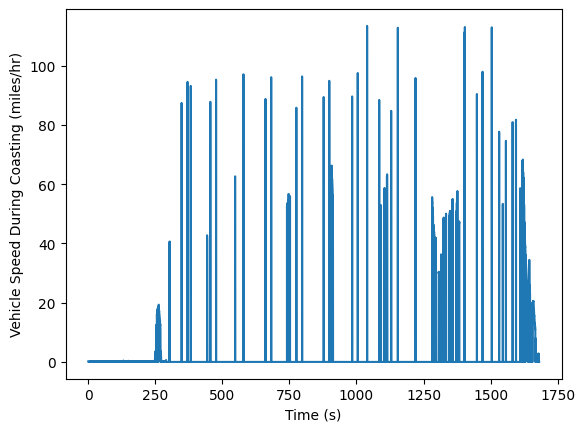

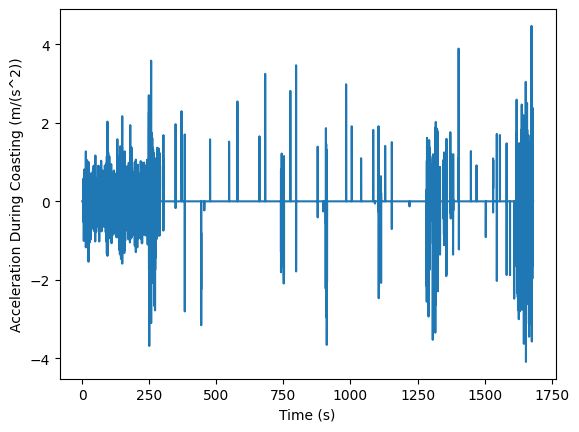

In [5]:
speed_during_coast = RACE_DATA_DF['GPS Speed'] * RACE_DATA_DF['GPS CST On']
plot_data(RACE_DATA_DF['Time'], f'Time ({UNITS["Time"]})', speed_during_coast.pint.to('miles/hr'), 'Vehicle Speed During Coasting (miles/hr)')

acceleration_during_coast = RACE_DATA_DF['GPS Speed'].diff().fillna(0) * RACE_DATA_DF['GPS CST On'] / RACE_DATA_DF['dT'].replace(0, np.nan)
plot_data(RACE_DATA_DF['Time'], f'Time ({UNITS["Time"]})', acceleration_during_coast.pint.to('m/(s^2)'), 'Acceleration During Coasting (m/(s^2))')